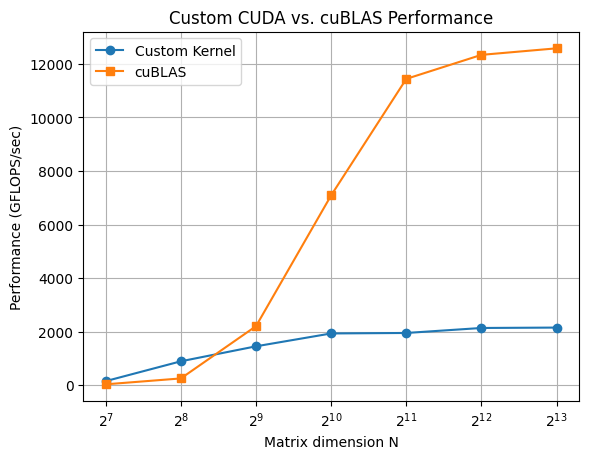

In [2]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# load your PTX once
mod    = cp.RawModule(path='matmul_kernel.ptx')
kernel = mod.get_function('matmul_kernel')

alpha, beta = 1.0, 10.0
sizes = [128 * (2**i) for i in range(7)]  # 128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144

custom_times = []
cublas_times = []

# warm up cuBLAS
_ = cp.random.random((512,512), dtype=cp.float32).dot(
       cp.random.random((512,512), dtype=cp.float32))
cp.cuda.Stream.null.synchronize()

for N in sizes:
    A = cp.random.random((N, N), dtype=cp.float32)
    B = cp.random.random((N, N), dtype=cp.float32)
    C = cp.random.random((N, N), dtype=cp.float32)
    TILE = 32
    grid = ((N + TILE - 1)//TILE, (N + TILE - 1)//TILE)
    block = (TILE, TILE)

    # warm-up custom kernel
    kernel(grid, block, (A, B, C, np.int32(N), np.float32(alpha), np.float32(beta)))
    cp.cuda.Stream.null.synchronize()

    # benchmark custom kernel (average of 20 runs)
    tck = 0.0
    for _ in range(20):
        s = cp.cuda.Event(); e = cp.cuda.Event()
        s.record()
        kernel(grid, block, (A, B, C, np.int32(N), np.float32(alpha), np.float32(beta)))
        e.record(); e.synchronize()
        tck += cp.cuda.get_elapsed_time(s, e)
    custom_times.append(tck/20)

    # benchmark cuBLAS (A.dot(B)) likewise
    tcb = 0.0
    C2 = C
    for _ in range(20):
        s = cp.cuda.Event(); e = cp.cuda.Event()
        s.record()
        C2 = alpha * A.dot(B) + beta * C2
        e.record(); e.synchronize()
        tcb += cp.cuda.get_elapsed_time(s, e)
    cublas_times.append(tcb/20)

# convert to GFLOPS/sec
custom_gflops = [(2*(N**3))/(t*1e6) for N, t in zip(sizes, custom_times)]
cublas_gflops = [(2*(N**3))/(t*1e6) for N, t in zip(sizes, cublas_times)]

# plot performance
plt.figure()
plt.plot(sizes, custom_gflops, '-o', label='Custom Kernel')
plt.plot(sizes, cublas_gflops,  '-s', label='cuBLAS')
plt.xscale('log', base=2)
plt.xlabel('Matrix dimension N')
plt.ylabel('Performance (GFLOPS/sec)')
plt.title('Custom CUDA vs. cuBLAS Performance')
plt.legend()
plt.grid(True)
plt.show()
